In [164]:
import torch
torch.cuda.get_device_name()

'Tesla K80'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import


In [4]:
!pip install transformers

     |████████████████████████████████| 675kB 7.0MB/s 
     |████████████████████████████████| 890kB 15.0MB/s 
     |████████████████████████████████| 1.1MB 37.4MB/s 
     |████████████████████████████████| 3.8MB 40.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=c496c9a95ac5048f348ca0a2a4e5359fd34a2d522159dd8475b0a901b848e314
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [165]:
from transformers import BertModel, BertTokenizer
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import metrics
import torch

import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

import pandas as pd
import numpy as np
import math

import random
import os

In [166]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Parse data


In [167]:
def Parse_data(file_path: str):
  """
  Parses csv file with extra commas, starts from right side of line,
  and goes to the left with column appending untill meets first column name
  :param file_path: path to csv text
  :returns: dataframe with 2 coloumns
  """
  with open(file_path) as f:
    df_dict = {name: list() for name in f.readline().strip().split(',')}
    keys = list(df_dict.keys())

    for line in f:
      separated_text = line.strip().split(',')
      for i in range(-1, -len(keys)-1, -1):
        if i != -len(keys):
          df_dict[keys[i]].append(separated_text[i])
          separated_text.pop()
        else:
          df_dict[keys[i]].append(' '.join(separated_text))

  train_df = pd.DataFrame.from_dict(df_dict)
  return train_df


train_df = Parse_data('/content/drive/My Drive/train.csv')

In [168]:
train_df.head(10), train_df.shape

(                                                text label
 0                                         ENT магнит     0
 1  Сообщение от подписчиков Поступило сообщение о...    -1
 2  Курт Воннегут « Колыбель для кошки » Продолжаю...     1
 3  Надо поугарать взять пакет из магнита и закупи...     0
 4  👌🏻☝🏻👏🏻👏🏻👏🏻 ширли-мырли-5.gif Кто все эти люди ...     0
 5  Овер сладкая хуйня пить невозможно в первый ра...    -1
 6                            Сегодняшний поход в ENT     0
 7  С праздником дорогие дамы хочу вырозить огромн...     1
 8  В рамках реализации федерального партийного пр...    -1
 9  Петроглиф автоматизация бизнеса О последствиях...     1, (23253, 2))

# Delete all non-cyrillic text

In [169]:
pattern = re.compile(r"[А-Яа-я]+|ENT")

splited_text = [re.findall(pattern, text) for text in train_df['text']]

In [170]:
filtred_df = pd.DataFrame({'text' : [' '.join(splited_text[i]) for i in range(len(splited_text))],
                           'label': train_df.label})

In [171]:
filtred_df.head(), filtred_df.shape

(                                                text label
 0                                         ENT магнит     0
 1  Сообщение от подписчиков Поступило сообщение о...    -1
 2  Курт Воннегут Колыбель для кошки Продолжаю мой...     1
 3  Надо поугарать взять пакет из магнита и закупи...     0
 4  ширли мырли Кто все эти люди которые пишут ста...     0, (23253, 2))

# Calculate review length

In [172]:
lens_list = [len(text) for text in splited_text]
lens_list = sorted(lens_list)[:-100]

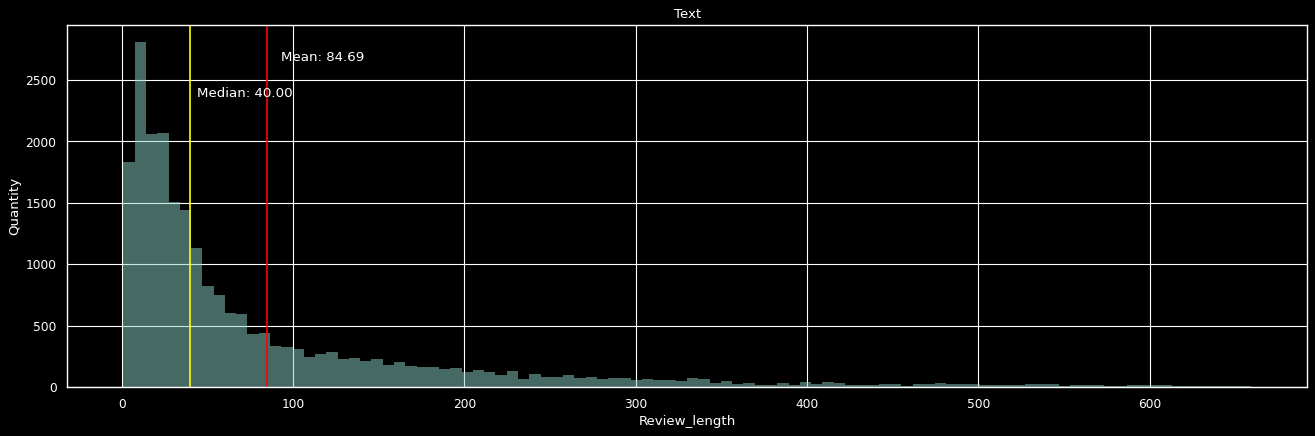

In [173]:
plt.style.use('dark_background')

figure(num=None, figsize=(20, 6), dpi=80, edgecolor='k')

plt.axvline(x=np.mean(lens_list), color='red', linestyle='-')
plt.axvline(x=np.median(lens_list), color='yellow', linestyle='-')
plt.hist(lens_list , bins=100, alpha=0.5,
            histtype='stepfilled',
            edgecolor='none')
plt.xticks(np.arange(min(lens_list)-1, max(lens_list), 100.0))
plt.title("Text")
plt.ylabel('Quantity')
plt.xlabel('Review_length')

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(lens_list)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(lens_list)));
plt.text(np.median(lens_list)*1.1, max_ylim*0.8, 'Median: {:.2f}'.format(np.median(lens_list)));

# ENT position

In [174]:
def find_tgt_token_pos(tokenized_texts: list, target_token: str):
  """
  Finding target token entry position in tokenized texts
  :param tokenized_texts: list with tokenized texts
  :param target_token: target token str
  :returns: list with int positions
  """
  target_token_position = list()
  length = len(tokenized_texts)
  for i in range(length):
    if target_token in tokenized_texts[i]:
      target_token_position.append(np.where(np.array(tokenized_texts[i]) == target_token)[0][0])
  return target_token_position

ENT_position = find_tgt_token_pos(splited_text, target_token='ENT')
ENT_position = sorted(ENT_position)[:-100]

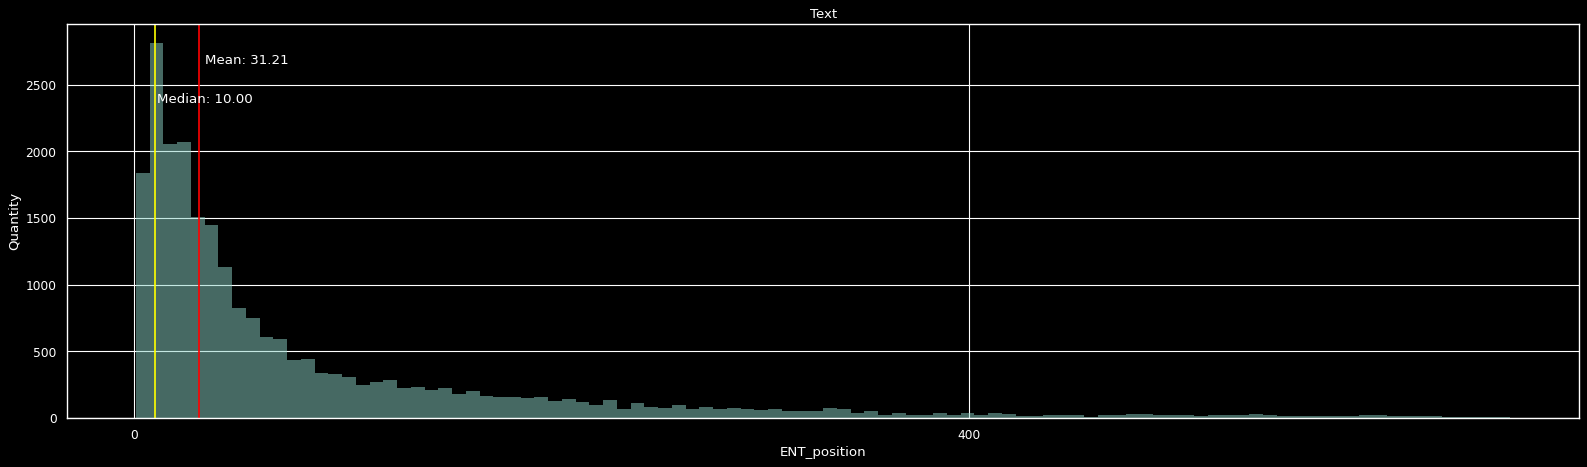

In [175]:
plt.style.use('dark_background')

figure(num=None, figsize=(20, 6), dpi=80, edgecolor='k')

plt.axvline(x=np.mean(ENT_position), color='red', linestyle='-')
plt.axvline(x=np.median(ENT_position), color='yellow', linestyle='-')
plt.hist(lens_list , bins=100, alpha=0.5,
            histtype='stepfilled',
            edgecolor='none')
plt.xticks(np.arange(min(ENT_position), max(ENT_position), 400.0))
plt.title("Text")
plt.ylabel('Quantity')
plt.xlabel('ENT_position')

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(ENT_position)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(ENT_position)));
plt.text(np.median(ENT_position)*1.1, max_ylim*0.8, 'Median: {:.2f}'.format(np.median(ENT_position)));
plt.tight_layout();

# Prepare chuncks for BERT

In [176]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

def get_labels(text_array: list, text_labels: list, target_token: str):
  """
  Delete all labels position where is no target token in text
  :param text_array: raw text array
  :param text_labels: text labels array
  :param target_token: target token str
  :returns: list with int labels
  """
  labels_list = list()
  for i, text in enumerate(text_array):
    if target_token in text:
      labels_list.append(text_labels[i])
  return(labels_list)

def tokenize_text(texts_array: list, target_token: str):
  """
  Tokenizes raw texts
  :param text_array: raw text array
  :param target_token: target token str
  :returns: list of lists with tokens
  """
  tokenized_text = list()
  for text in texts_array:
    tokenized = tokenizer.tokenize(text)
    if target_token in tokenized:
      tokenized_text.append(tokenized)
  return tokenized_text

def PAD_text(text_for_pad: list, pad_length: int, pad_token: str, bos_token: str, eos_token: str):
  """
  Pad and add special tokens to sequence
  :param text_for_pad: list with tokens
  :param pad_length: int padding length
  :param pad_token: pad token str
  :param bos_token: begin of sequence token str
  :param eos_token: end of sequence token str
  :returns: list with tokens
  """
  return [bos_token] + text_for_pad + [pad_token for i in range(pad_length)] + [eos_token]

def normalize_text_chunck(tokenized_texts: list, target_tok_pos: list, chunck_length: int, pad_token: str, bos_token: str, eos_token: str):
  """
  Creates array with text chuncks for feeding to BERT
  :param tokenized_texts: list of lists with tokens
  :param target_token: target token str
  :param chunck_length: int chunck length
  :param pad_token: pad token str
  :param bos_token: begin of sequence token str
  :param eos_token: end of sequence token str
  :returns: list with chuncks
  """
  normalized_chuncks = list()
  chunck_center = math.ceil(chunck_length/2)
  for i, text in enumerate(tokenized_text):
    chunck_start = max(0, target_tok_pos[i]-chunck_center+1)
    chunck_end = min(len(text), target_tok_pos[i]+chunck_center-2)
    text_for_PAD = text[chunck_start: chunck_end]
    pad_length = chunck_length - len(text_for_PAD) - 2
    normalized_chuncks.append(PAD_text(text_for_PAD, pad_length, pad_token, bos_token, eos_token))
  return normalized_chuncks

In [177]:
#create array with labels for clastering
labels_list = get_labels(filtred_df.text, filtred_df.label, target_token='ENT')
#tokenize text for chuncks
tokenized_text = tokenize_text(filtred_df.text, target_token='ent')
#find target entity position for chuncks
ENT_position = find_tgt_token_pos(tokenized_text, target_token='ent')
#create chuncks
normalized_text_chuncks = normalize_text_chunck(tokenized_text, ENT_position, chunck_length=83, pad_token='[PAD]', bos_token='[CLS]', eos_token='[SEP]')

# Check our chuncks

In [220]:
def check_chuncks(chuncks, chunck_length, tgt_token, pad_token, bos_token, eos_token):
  """
  Chceking chuncks for some canditions 
  :param chuncks: list of lists with tokens
  :param chunck_length: int chunck length
  :param tgt_token: target token
  :param pad_token: pad token str
  :param bos_token: begin of sequence token str
  :param eos_token: end of sequence token str
  :returns: bool
  """
  bos_flag = all([txt[0] == bos_token for txt in chuncks])
  eos_flag = all([txt[-1] == eos_token for txt in chuncks])
  tgt_flag = all([tgt_token in txt for txt in chuncks])
  lengths_flag = all([len(text) == chunck_length for text in chuncks])
  count_padded = sum([pad_token in txt for txt in chuncks])
  print(f"""\tAll chuncks start with {bos_token}: {bos_flag} |\n 
        All chuncks end with {eos_token}: {eos_flag} |\n
        All chuncks contains target token {tgt_token}: {eos_flag} |\n
        All chuncks have the same length: {lengths_flag} |\n 
        Chunks padded: {count_padded} |""")

check_chuncks(normalized_text_chuncks, 
              chunck_length=83,
              tgt_token='ent',
              pad_token='[PAD]', 
              bos_token='[CLS]', 
              eos_token='[SEP]')

	All chuncks start with [CLS]: True |
 
        All chuncks end with [SEP]: True |

        All chuncks contains target token ent: True |

        All chuncks have the same length: True |
 
        Chunks padded: 19524 |


# Modeling

In [179]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertModel.from_pretrained("DeepPavlov/rubert-base-cased").to(device)

# Extract Vectors

In [180]:
def make_mask(seq: torch.tensor, seq_pad_idx: int, device: torch.device):
  """
  Creates mask using for BERTmodel
  :param seq: torch tensor
  :param seq_pad_idx: pad token id
  :param device: cuda or cpu torch device
  :returns: torch tensor mask with bool type
  """
  mask = (seq != seq_pad_idx).to(device)
  return mask

In [181]:
from IPython.display import clear_output

def extract_vectors(model: model, text_chuncks: list, pad_idx: int, device: torch.device):
  """
  Extract vectorized text chunck representation by feeding them to pretrained model
  :model: pytorch NLP model
  :param text_chuncks: list of lists with token indexes
  :param pad_idx: pad token id
  :param device: cuda or cpu torch device
  :returns: numpy array with vectors
  """
  vector_length = model.config.hidden_size
  vectors_array = np.array([[int() for i in range(vector_length)]])

  for number, chunck in enumerate(text_chuncks):
    txt_ids = torch.tensor(tokenizer.encode(chunck, add_special_tokens=False)).unsqueeze(0).to(device)
    mask = make_mask(txt_ids, pad_idx, device)
    
    outputs = model(input_ids=txt_ids, 
                    attention_mask=mask)
    
    vectors_array = np.vstack((vectors_array, outputs[1].detach().cpu().numpy()))

    print(f'chuncks vectorized: {number+1}')
    clear_output(wait=True)

  vectors_array = np.delete(vectors_array, 0, axis=0)
  return vectors_array

In [182]:
seq_pad_idx = tokenizer.pad_token_id
vectors = extract_vectors(model, normalized_text_chuncks, seq_pad_idx, device)

chuncks vectorized: 23252


# Dimensionality reduction

## TSNE

In [183]:
target = np.array(labels_list)

In [184]:
tsne = TSNE(n_components=2, init='pca')

proj_TSNE = tsne.fit_transform(vectors)

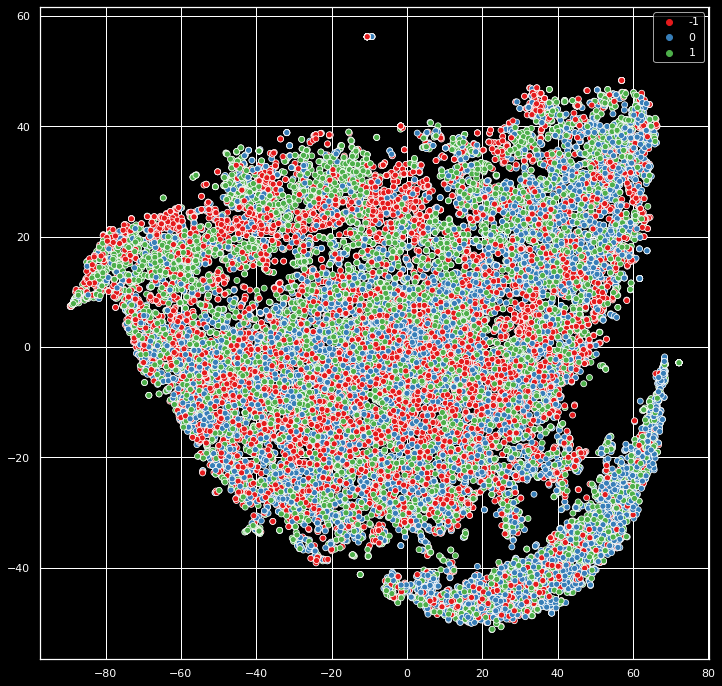

In [185]:
plt.style.use('dark_background')
ax = sns.scatterplot(x=proj_TSNE[:, 0], 
                     y=proj_TSNE[:, 1], 
                     hue=target, 
                     palette="Set1")
sns.set(rc={'figure.figsize':(12, 12)})

## PCA

In [186]:
pca = PCA(n_components=2)

proj_PCA = pca.fit_transform(vectors)

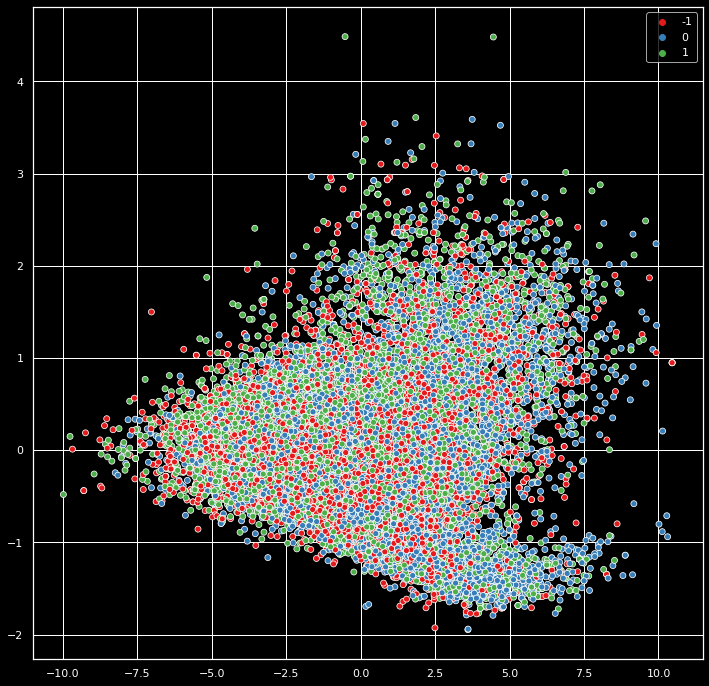

In [187]:
plt.style.use('dark_background')
ax = sns.scatterplot(x=proj_PCA[:, 0], 
                     y=proj_PCA[:, 1], 
                     hue=target, 
                     palette="Set1")
sns.set(rc={'figure.figsize':(12, 12)})

# Clustering

## DBSCAN with PCA

In [188]:
db_eps_1 = DBSCAN(eps=0.05, min_samples=10).fit(proj_PCA)
db_eps_2 = DBSCAN(eps=0.1, min_samples=10).fit(proj_PCA)
db_eps_3 = DBSCAN(eps=0.15, min_samples=10).fit(proj_PCA)
db_eps_4 = DBSCAN(eps=0.2, min_samples=10).fit(proj_PCA)
db_eps_5 = DBSCAN(eps=0.25, min_samples=10).fit(proj_PCA)
db_eps_6 = DBSCAN(eps=0.3, min_samples=10).fit(proj_PCA)

In [189]:
labels_true = target
models_list = [db_eps_1, db_eps_2, db_eps_3, db_eps_4, db_eps_5, db_eps_6]
metric_dict = {'Homogeneity': list(),
               'Completeness': list(),
               'V-measure': list(),
               'Adjusted Rand Index': list(),
               'Adjusted Mutual Information': list(),
               'Silhouette Coefficient': list()}

clusters_dict = {'N_clusters': list(),
               'n_noise': list()}

for i, model in enumerate(models_list):
  labels = model.labels_
  clusters_dict['N_clusters'].append(len(set(labels)) - (1 if -1 in labels else 0))
  clusters_dict['n_noise'].append(list(labels).count(-1))
  metric_dict['Homogeneity'].append(metrics.homogeneity_score(labels_true, labels))
  metric_dict['Completeness'].append(metrics.completeness_score(labels_true, labels))
  metric_dict['V-measure'].append(metrics.v_measure_score(labels_true, labels))
  metric_dict['Adjusted Rand Index'].append(metrics.adjusted_rand_score(labels_true, labels))
  metric_dict['Adjusted Mutual Information'].append(metrics.adjusted_mutual_info_score(labels_true, labels))
  metric_dict['Silhouette Coefficient'].append(metrics.silhouette_score(vectors, labels))

stats_df = pd.DataFrame(metric_dict, index=['N_clusters='+str(clusters_dict['N_clusters'][i]) for i in range(0, 6)])

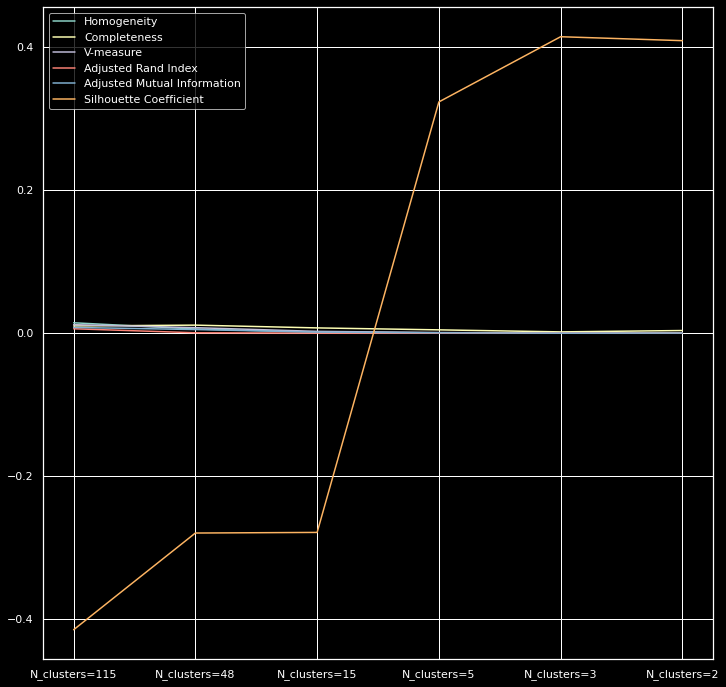

In [190]:
plt.style.use('dark_background')
stats_df.plot(figsize=(12,12));

## DBSCAN with TSNE

In [191]:
db_eps_1 = DBSCAN(eps=0.05, min_samples=10).fit(proj_TSNE)
db_eps_2 = DBSCAN(eps=0.1, min_samples=10).fit(proj_TSNE)
db_eps_3 = DBSCAN(eps=0.15, min_samples=10).fit(proj_TSNE)
db_eps_4 = DBSCAN(eps=0.2, min_samples=10).fit(proj_TSNE)
db_eps_5 = DBSCAN(eps=0.25, min_samples=10).fit(proj_TSNE)
db_eps_6 = DBSCAN(eps=0.3, min_samples=10).fit(proj_TSNE)

In [192]:
labels_true = target
models_list = [db_eps_1, db_eps_2, db_eps_3, db_eps_4, db_eps_5, db_eps_6]
metric_dict = {'Homogeneity': list(),
               'Completeness': list(),
               'V-measure': list(),
               'Adjusted Rand Index': list(),
               'Adjusted Mutual Information': list(),
               'Silhouette Coefficient': list()}

clusters_dict = {'N_clusters': list(),
               'n_noise': list()}

for i, model in enumerate(models_list):
  labels = model.labels_
  clusters_dict['N_clusters'].append(len(set(labels)) - (1 if -1 in labels else 0))
  clusters_dict['n_noise'].append(list(labels).count(-1))
  metric_dict['Homogeneity'].append(metrics.homogeneity_score(labels_true, labels))
  metric_dict['Completeness'].append(metrics.completeness_score(labels_true, labels))
  metric_dict['V-measure'].append(metrics.v_measure_score(labels_true, labels))
  metric_dict['Adjusted Rand Index'].append(metrics.adjusted_rand_score(labels_true, labels))
  metric_dict['Adjusted Mutual Information'].append(metrics.adjusted_mutual_info_score(labels_true, labels))
  metric_dict['Silhouette Coefficient'].append(metrics.silhouette_score(vectors, labels))

stats_df = pd.DataFrame(metric_dict, index=['N_clusters='+str(clusters_dict['N_clusters'][i]) for i in range(0, 6)])

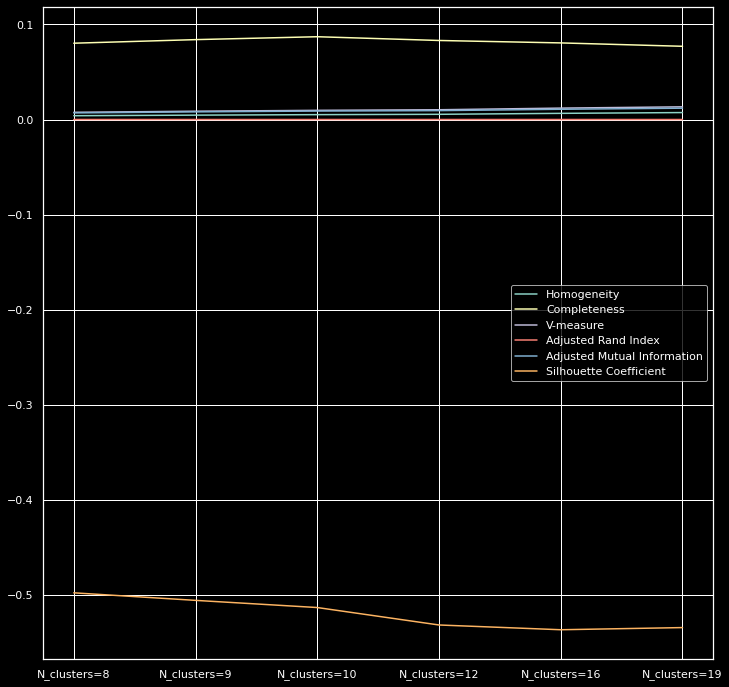

In [193]:
plt.style.use('dark_background')
stats_df.plot(figsize=(12,12));

## KMeans with PCA

In [194]:
kmeans_3 = KMeans(n_clusters=3).fit(proj_PCA)
kmeans_4 = KMeans(n_clusters=4).fit(proj_PCA)
kmeans_5 = KMeans(n_clusters=5).fit(proj_PCA)
kmeans_6 = KMeans(n_clusters=6).fit(proj_PCA)
kmeans_7 = KMeans(n_clusters=7).fit(proj_PCA)
kmeans_8 = KMeans(n_clusters=8).fit(proj_PCA)

In [195]:
labels_true = target
models_list = [kmeans_3, kmeans_4, kmeans_5, kmeans_6, kmeans_7, kmeans_8]
metric_dict = {'Homogeneity': list(),
               'Completeness': list(),
               'V-measure': list(),
               'Adjusted Rand Index': list(),
               'Adjusted Mutual Information': list(),
               'Silhouette Coefficient': list()}

for model in models_list:
  labels = model.labels_
  metric_dict['Homogeneity'].append(metrics.homogeneity_score(labels_true, labels))
  metric_dict['Completeness'].append(metrics.completeness_score(labels_true, labels))
  metric_dict['V-measure'].append(metrics.v_measure_score(labels_true, labels))
  metric_dict['Adjusted Rand Index'].append(metrics.adjusted_rand_score(labels_true, labels))
  metric_dict['Adjusted Mutual Information'].append(metrics.adjusted_mutual_info_score(labels_true, labels))
  metric_dict['Silhouette Coefficient'].append(metrics.silhouette_score(vectors, labels))

stats_df = pd.DataFrame(metric_dict, index=['KMean'+str(i) for i in range(3, 9)])

### Visualize KMeans with PCA

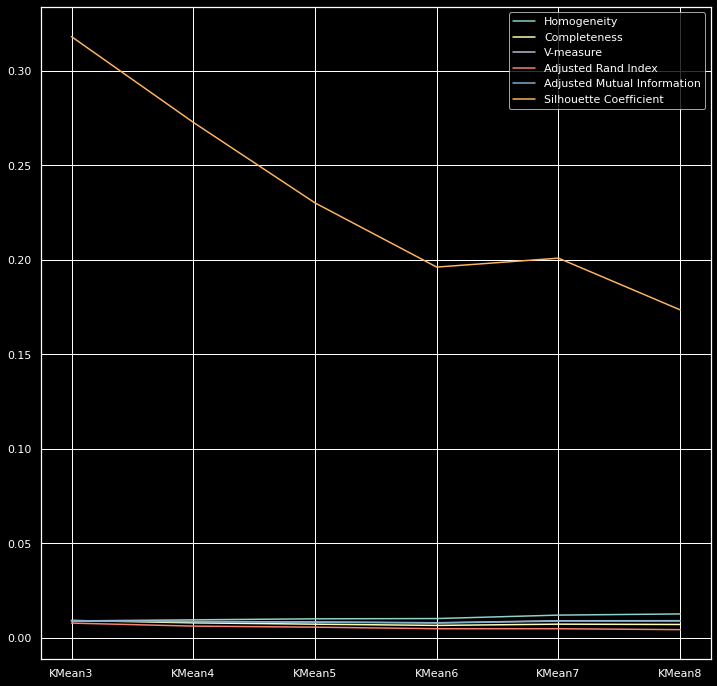

In [196]:
plt.style.use('dark_background')
stats_df.plot(figsize=(12,12));

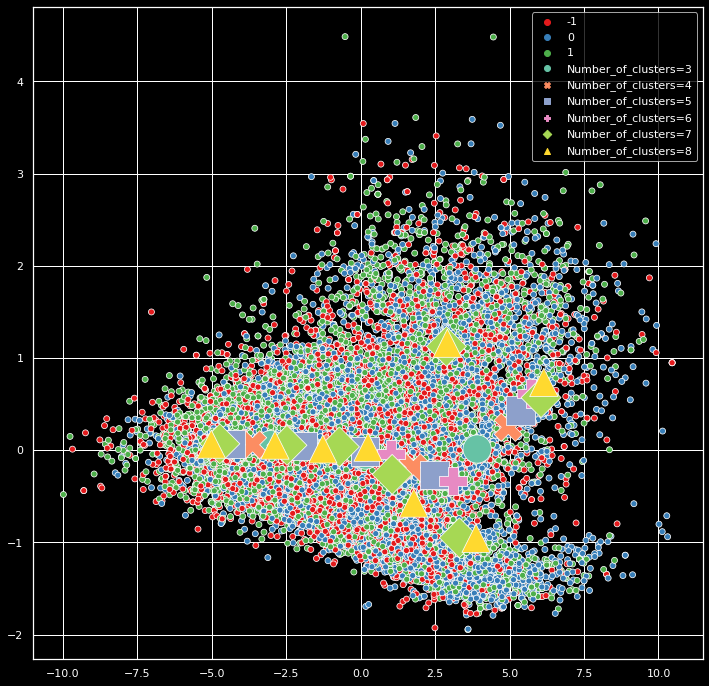

In [197]:
def visualize_clusters(cluster_num, models_list):
  """
  visualizes clusters less or equal number of centers
  :param cluster_num: int max number of clusters
  :param models_list: list with models
  :returns: plot
  """
  centers = list()
  center_quantity = list()
  for model in models_list[:cluster_num-2]:
    number_of_centers = len(model.cluster_centers_)
    centers.append(model.cluster_centers_)
    center_quantity += ["Number_of_clusters="+str(number_of_centers) for i in range(number_of_centers)]

  centers = np.concatenate(centers)

  plt.style.use('dark_background')
  ax = sns.scatterplot(x=proj_TSNE[:, 0],
                       y=proj_TSNE[:, 1], 
                       hue=target, 
                       palette="Set1")
  ax = sns.scatterplot(x=centers[:, 0], 
                       y=centers[:, 1], 
                       hue=center_quantity, 
                       style=center_quantity, 
                       palette="Set2", s=800)
  sns.set(rc={'figure.figsize':(12, 12)})

visualize_clusters(cluster_num=8, models_list=models_list)

## KMeans with TSNE

In [209]:
kmeans_3 = KMeans(n_clusters=3).fit(proj_TSNE)
kmeans_4 = KMeans(n_clusters=4).fit(proj_TSNE)
kmeans_5 = KMeans(n_clusters=5).fit(proj_TSNE)
kmeans_6 = KMeans(n_clusters=6).fit(proj_TSNE)
kmeans_7 = KMeans(n_clusters=7).fit(proj_TSNE)
kmeans_8 = KMeans(n_clusters=8).fit(proj_TSNE)

In [210]:
labels_true = target
models_list = [kmeans_3, kmeans_4, kmeans_5, kmeans_6, kmeans_7, kmeans_8]
metric_dict = {'Homogeneity': list(),
               'Completeness': list(),
               'V-measure': list(),
               'Adjusted Rand Index': list(),
               'Adjusted Mutual Information': list(),
               'Silhouette Coefficient': list()}

for model in models_list:
  labels = model.labels_
  metric_dict['Homogeneity'].append(metrics.homogeneity_score(labels_true, labels))
  metric_dict['Completeness'].append(metrics.completeness_score(labels_true, labels))
  metric_dict['V-measure'].append(metrics.v_measure_score(labels_true, labels))
  metric_dict['Adjusted Rand Index'].append(metrics.adjusted_rand_score(labels_true, labels))
  metric_dict['Adjusted Mutual Information'].append(metrics.adjusted_mutual_info_score(labels_true, labels))
  metric_dict['Silhouette Coefficient'].append(metrics.silhouette_score(vectors, labels))

stats_df = pd.DataFrame(metric_dict, index=['KMean'+str(i) for i in range(3, 9)])

### Visualize KMeans with TSNE

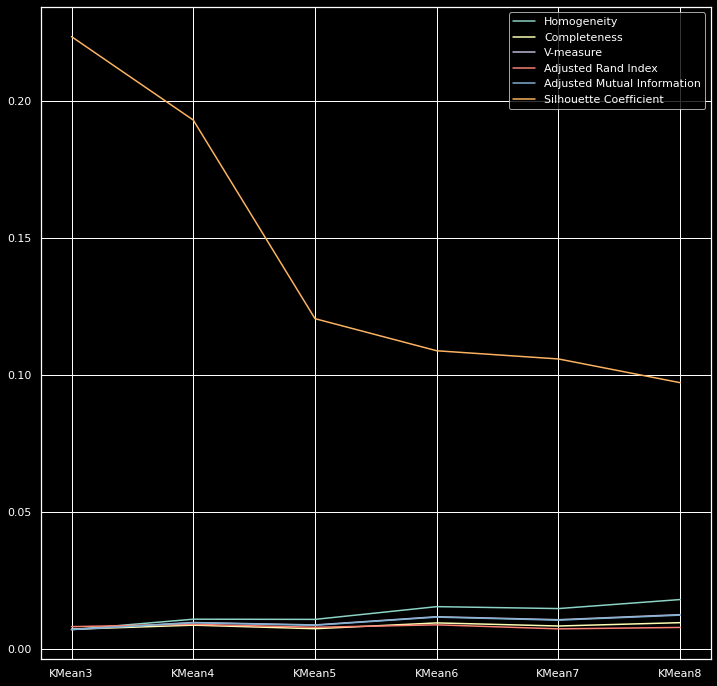

In [211]:
plt.style.use('dark_background')
stats_df.plot(figsize=(12,12));

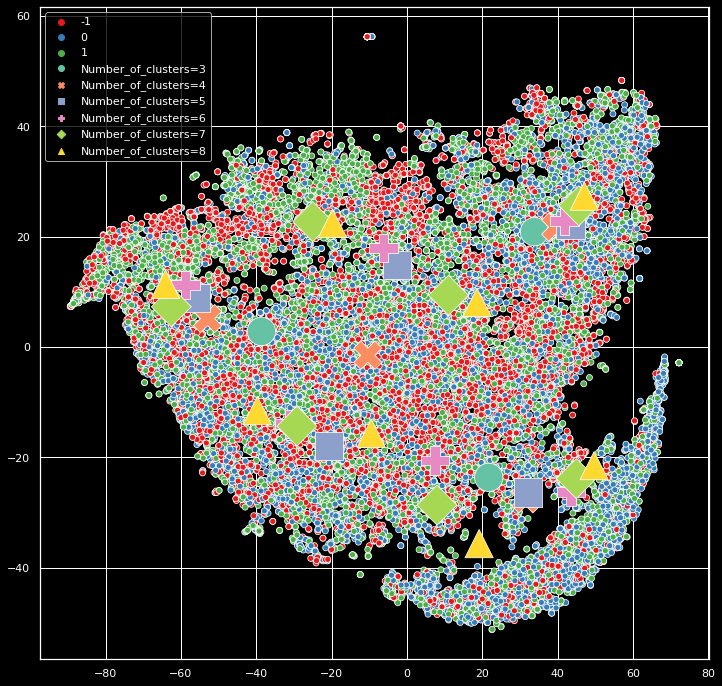

In [212]:
def visualize_clusters(cluster_num, models_list):
  """
  visualizes clusters less or equal number of centers
  :param cluster_num: int max number of clusters
  :param models_list: list with models
  :returns: plot
  """
  centers = list()
  center_quantity = list()
  for model in models_list[:cluster_num-2]:
    number_of_centers = len(model.cluster_centers_)
    centers.append(model.cluster_centers_)
    center_quantity += ["Number_of_clusters="+str(number_of_centers) for i in range(number_of_centers)]

  centers = np.concatenate(centers)

  plt.style.use('dark_background')
  ax = sns.scatterplot(x=proj_TSNE[:, 0],
                       y=proj_TSNE[:, 1], 
                       hue=target, 
                       palette="Set1")
  ax = sns.scatterplot(x=centers[:, 0], 
                       y=centers[:, 1], 
                       hue=center_quantity, 
                       style=center_quantity, 
                       palette="Set2", s=800)
  sns.set(rc={'figure.figsize':(12, 12)})

visualize_clusters(cluster_num=8, models_list=models_list)

## Agglomerative Clustering with PCA

In [214]:
aglm_3 = AgglomerativeClustering(n_clusters=3).fit(proj_PCA)
aglm_4 = AgglomerativeClustering(n_clusters=4).fit(proj_PCA)
aglm_5 = AgglomerativeClustering(n_clusters=5).fit(proj_PCA)
aglm_6 = AgglomerativeClustering(n_clusters=6).fit(proj_PCA)
aglm_7 = AgglomerativeClustering(n_clusters=7).fit(proj_PCA)
aglm_8 = AgglomerativeClustering(n_clusters=8).fit(proj_PCA)

In [215]:
labels_true = target
models_list = [aglm_3, aglm_4, aglm_5, aglm_6, aglm_7, aglm_8]
metric_dict = {'Homogeneity': list(),
               'Completeness': list(),
               'V-measure': list(),
               'Adjusted Rand Index': list(),
               'Adjusted Mutual Information': list(),
               'Silhouette Coefficient': list()}

for model in models_list:
  labels = model.labels_
  metric_dict['Homogeneity'].append(metrics.homogeneity_score(labels_true, labels))
  metric_dict['Completeness'].append(metrics.completeness_score(labels_true, labels))
  metric_dict['V-measure'].append(metrics.v_measure_score(labels_true, labels))
  metric_dict['Adjusted Rand Index'].append(metrics.adjusted_rand_score(labels_true, labels))
  metric_dict['Adjusted Mutual Information'].append(metrics.adjusted_mutual_info_score(labels_true, labels))
  metric_dict['Silhouette Coefficient'].append(metrics.silhouette_score(vectors, labels))

stats_df = pd.DataFrame(metric_dict, index=['KMean'+str(i) for i in range(3, 9)])

### Visualize Agglomerative Clustering with PCA

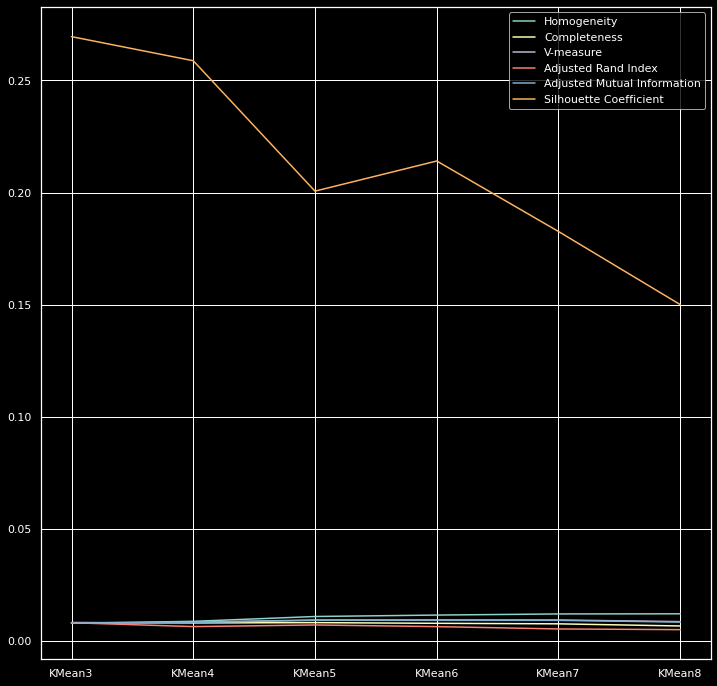

In [216]:
plt.style.use('dark_background')
stats_df.plot(figsize=(12,12));

## Agglomerative Clustering with TSNE

In [226]:
aglm_3 = AgglomerativeClustering(n_clusters=3).fit(proj_TSNE)
aglm_4 = AgglomerativeClustering(n_clusters=4).fit(proj_TSNE)
aglm_5 = AgglomerativeClustering(n_clusters=5).fit(proj_TSNE)
aglm_6 = AgglomerativeClustering(n_clusters=6).fit(proj_TSNE)
aglm_7 = AgglomerativeClustering(n_clusters=7).fit(proj_TSNE)
aglm_8 = AgglomerativeClustering(n_clusters=8).fit(proj_TSNE)

In [227]:
labels_true = target
models_list = [aglm_3, aglm_4, aglm_5, aglm_6, aglm_7, aglm_8]
metric_dict = {'Homogeneity': list(),
               'Completeness': list(),
               'V-measure': list(),
               'Adjusted Rand Index': list(),
               'Adjusted Mutual Information': list(),
               'Silhouette Coefficient': list()}

for model in models_list:
  labels = model.labels_
  metric_dict['Homogeneity'].append(metrics.homogeneity_score(labels_true, labels))
  metric_dict['Completeness'].append(metrics.completeness_score(labels_true, labels))
  metric_dict['V-measure'].append(metrics.v_measure_score(labels_true, labels))
  metric_dict['Adjusted Rand Index'].append(metrics.adjusted_rand_score(labels_true, labels))
  metric_dict['Adjusted Mutual Information'].append(metrics.adjusted_mutual_info_score(labels_true, labels))
  metric_dict['Silhouette Coefficient'].append(metrics.silhouette_score(vectors, labels))

stats_df = pd.DataFrame(metric_dict, index=['KMean'+str(i) for i in range(3, 9)])

### Visualize Agglomerative Clustering with TSNE

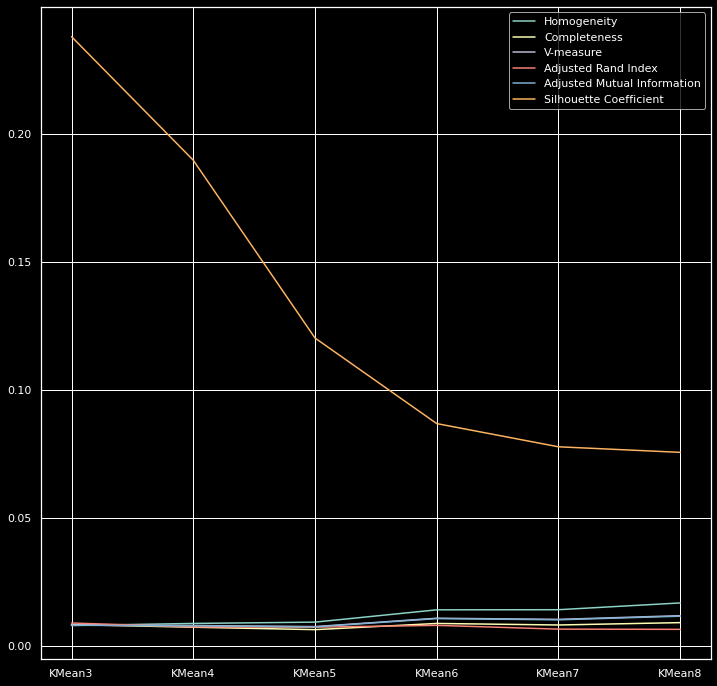

In [228]:
plt.style.use('dark_background')
stats_df.plot(figsize=(12,12));